Below is code to numerically solve the phytoplankton concentration with distance from the ice edge, P(x), via the steady state equation of motion:
$$U\frac{\partial P}{\partial x} = \Gamma(P,D) P$$
where $U$ is the average flow speed normal to the ice edge and $\Gamma(P,D)$ is the net growth rate defined as
$$\Gamma(P,D) = \gamma I(P,D) - r - \frac{w_P}{D} - \frac{w(D)}{D}$$
for growth rate $\gamma$, normalized light intensity $I(P,D)$ average over the mixed layer depth $D$, death/respiration rate $r$, pytoplankton settling velocity $w_P$, and mixed layer depth evolution $w(D)$. The boundary conditions are $P(x=0)=P_0$ and $P(x\rightarrow \infty)=P_\infty$.

The depth averaged light inteensity is defined by $$I(\xi) = \xi^{-1}(1-e^{-\xi})$$ where $\xi = D/\ell_0 = D/\ell_f + PD/K_B$ for light attenuation length $\ell_f$ and biomass scale $K_B$.

The mixed layer depth evolves with distance from the ice edge as 
$$U\frac{\partial D}{\partial x} = w(D) = \frac{U}{L_D}D\left(1-\frac{D}{D_\infty}\right)$$ where $L_D$ is a saturation length and $D_\infty$ is the open ocean mixed layer depth. The solution to the above eqaution is
$$D(x) = \frac{D_\infty }{1 + \left(\frac{D_\infty}{D_0} - 1 \right)e^{-x/L_D}},$$ where $D_0$ is the mixed layer depth at the ice edge.

The solutions below are dimensionless were units are rescaled as follows: rates are rescaled by $\gamma$, horizontal lengths are rescaled by the bloom length scale $U/\gamma$, depths are rescaled by $D_0$, vertical velocities by $\gamma D_0$ and the plankton concentration by $P_0$.

In [1]:
## Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import optimize

#Setting figure parameters
plt.rcParams.update({
    'pgf.texsystem': "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.sans-serif': 'Computer Modern Sans Serif',
    'lines.linewidth': 3,
    'lines.markersize': 150**.5,
    'scatter.edgecolors': "k",
    'lines.markeredgecolor': "k",
    'axes.labelsize': 30,
    'font.size':    20,
    'figure.figsize': (10,8),
    'legend.frameon': False,
    'legend.fontsize': 23,
    'legend.title_fontsize': 25,
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.major.pad': 8,
    'xtick.minor.size': 4,
    'xtick.major.size': 8,
    'xtick.labelsize': 23,
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.size': 4,
    'ytick.major.size': 8,
    'ytick.labelsize': 23,
    'ytick.minor.visible': True,
    'scatter.edgecolors': 'k',
})

# function to create colorbar in figure below
def colorbar(AX,X0,Xf,label,pad=-80,fs=25,bpad=2,loc="upper right",norm=matplotlib.colors.Normalize(0,1)):

    p = AX.scatter(np.nan,np.nan,c=1,cmap=cmap,norm=norm)
    axin = inset_axes(
        AX,
        height="6.5%", 
        width="18%", 
        loc=loc,
        borderpad=bpad
    )
    cb=plt.colorbar(p,cax=axin, orientation="horizontal")
    cb.ax.set_xticks([0,1],[X0,Xf])
    cb.ax.set_xlabel(label,fontsize=fs,labelpad=pad)
    return cb



In [2]:

def Px(x,r,wP,LD,lf,KB,Df):
    """
    Steady state phytoplankton concentration P'(x') = P(x')/P_0
    
    Paramters (rescaled):
    ---------------------
    - x' = x/(U/gamma): array of distances from the ice edge
    - r' = r/gamma: death rate
    - w_P' = w_P/(gamma*D_0): sinking rate
    - L_D' = L_D/(U/gamma): mixed layer saturation length
    - l_f' = l_f/D_0: light attenuation length
    - K_B' = K_B/(P0*D0): Biomass scale
    - D_f' = D_f/D_0: open ocean mixed layer depth
    
    Returns distribution P'(x')
    
    """
    Nx = len(x) #number of x-bins
    
    dx = x[1]-x[0] # bin size (assumed uniform)
    
    P = np.ones(Nx) # initiate solution array
    
    #integrate equation of motion over x
    for i in range(Nx-1):
        
        D = Df/(1+(Df-1)*np.exp(-x[i]/LD)) #mixed layer depth D(x)
        
        Xi = D/lf + D*P[i]/KB
        I = 1/Xi*(1-np.exp(-Xi)) # normalized light intinsity 
        
        Gamma = I - r - wP/D - 1/LD*(1-D/Df) # net growth rate
        
        P[i+1] = P[i] + dx*Gamma*P[i] # simple forward integration
        
    return P #return P(x)


Below is a figure of numerical solutions $P(x)$ testing the dependence on the model parameters. This parameter sensitivity is contrainted to satisfy the the exponetial growth length scale L_P and the open ocean concentration $P_\infty$ stay constant at the measured values. (Parameters used are for the month of June--see main text and appendix.)

Text(14.75, 11, '(d)')

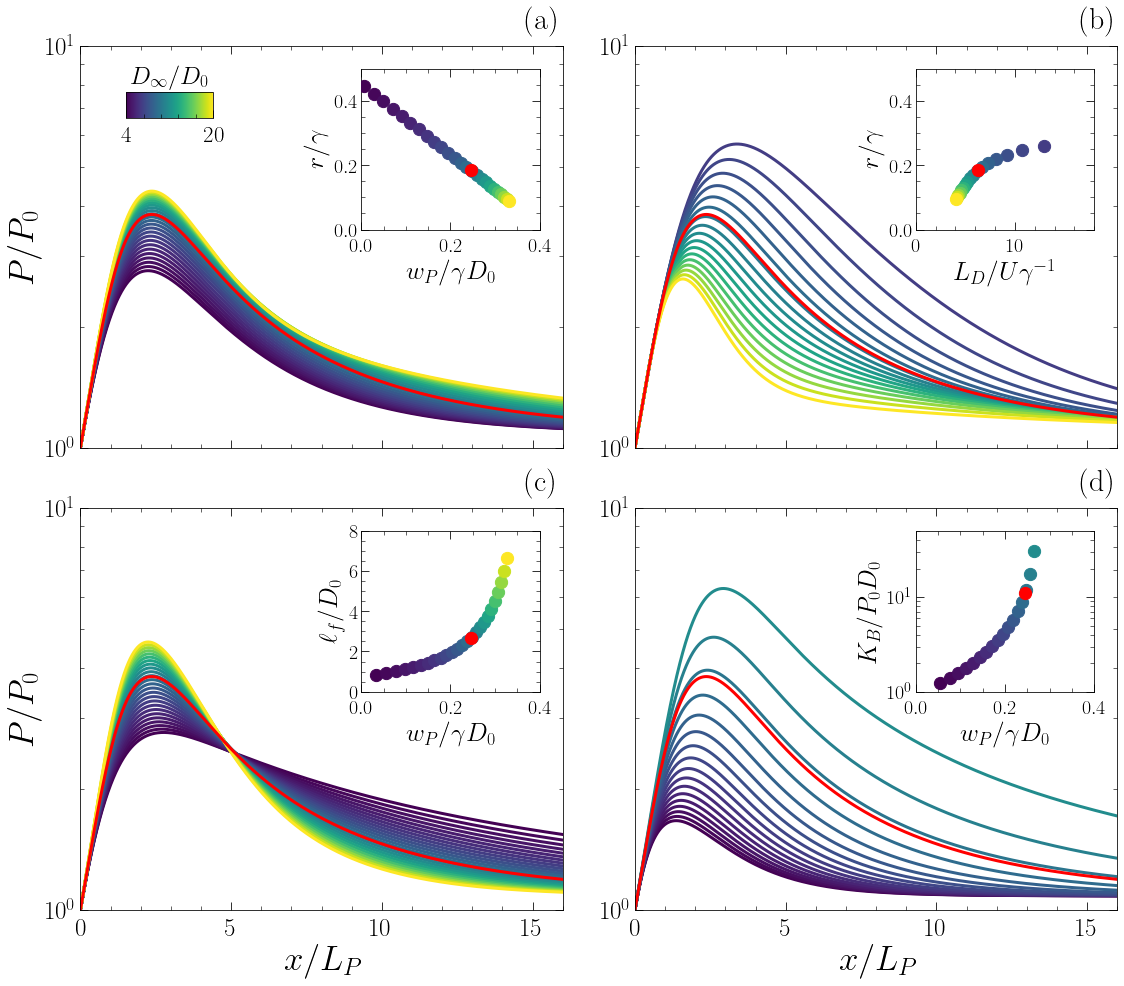

In [4]:
## Parameters for month June
P0 = 0.6 #mg/m^3
LP = 70 #km
Pf = 0.65 #mg/m^3
D0 = 7.5 #m 
LD = 100 #km 
r = 0.1 #1/day
wP = 1 #m/day
lf = 20 #m
KB = 50  #mg/m^2
U = 0.1*(3600*24)/1000 #km/day

#---------
# This block of code obtains gamma and D_infty from the constraints (see Appendix)

# Creating a function to optimize contstraints
def F(X):
    gamma,Df=X
    l0 = 1/(1/lf + P0/KB)
    I = l0/D0*(1-np.exp(-D0/l0))
    f0 = gamma*I - r - wP/D0 - U/LD*(1-D0/Df) - U/LP #contraint for measured bloom length scale L_P
    
    l0 = 1/(1/lf + Pf/KB)
    I = l0/Df*(1-np.exp(-Df/l0))
    ff = gamma*I - r - wP/Df #contraint for measured open ocean concentration P_infty
    return [f0,ff]

gamma,Df = optimize.fsolve(F,[0.5,75]) #finding roots F(gamma,D_infty) = 0
#---------


# Rescaled parameters
r_ = r/gamma
wP_ = wP/(D0*gamma) 
LD_ = LD/(U/gamma)
lf_ = lf/D0 
KB_ = KB/(P0*D0) 
Df_ = Df/D0 
Pf_ = Pf/P0
LP_ = LP/(U/gamma)


## Initializing constraint functions to be optimized 

def f_0(Df,r,wP,LD,lf=lf_,KB=KB_,LP=LP_):
    l0 = 1/(1/lf + 1/KB)
    I = l0*(1-np.exp(-1/l0))
    return I - r - wP - 1/LD*(1-1/Df) - 1/LP #contraint for measured bloom length scale L_P

def f_inf(Df,r,wP,lf=lf_,KB=KB_,Pf=Pf_):
    l0 = 1/(1/lf + Pf/KB)
    I = l0/Df*(1-np.exp(-Df/l0))
    return I - r - wP/Df #contraint for measured open ocean concentration P_infty




# Initializing rescaled distance from the ice edge 
x_ = np.linspace(0,1500,10000)/(U/gamma)

# Initializing rescaled solution P(x) for month of June
P_ = Px(x_, r_, wP_, LD_, lf_, KB_, Df_)



#Initialize 2x2 figure
fig,ax = plt.subplots(2,2,figsize=(18,15))

#initialized inset axes in each panel
axi= []
for i in [0,1]:
    for j in [0,1]:
        axi.append(inset_axes(
                ax[i,j],
                height="40%",  
                width="37%",  
                loc="upper right",
                borderpad=1))



Depth0=4 
Depthf=20
Depths = np.geomspace(Depth0,Depthf,25) #array of open ocean mixed layer depths D_infty/D_0


cmap = plt.cm.viridis #colormap used in figure
c = lambda D: cmap(matplotlib.colors.Normalize(Depth0,Depthf)(D)) #function for line/marker colors for D_infty/D_0


for Df_i in Depths: # iterate over mixed layer depth parameter D_infty/D_0

    # In this loop we obtain solutions P(x) while optemizing the constraints for a set of two parameters for 
    #   a given value D_infty/D_0 while while holding the other parameters fixed.
    
    
    # Solving for death rate r and sinking rate w_P
    def F(val):
        X1,X2=val
        return [f_0(r=X1,wP=X2,Df=Df_i,LD=LD_), 
              f_inf(r=X1,wP=X2,Df=Df_i) ] #optimizing function set
    
    Op = optimize.root(F,[r_,wP_]) # finding roots F=0
    val = Op.x
    if Op.success and val[0]>=0 and val[1]>=0: #if opimization solution found plot resulting P(x)
        r_m,wP_m = val        

        ## main panel plot P(x)
        ax[0,0].plot(x_/LP_,Px(x=x_, r=r_m, wP=wP_m , LD=LD_, Df=Df_i, 
                         lf=lf_, KB=KB_),
                    color=c(Df_i)) 
        
        ## inset parameter plot
        axi[0].scatter(wP_m,r_m,color=c(Df_i),zorder=Df_i)
        

    ## Same process is repeated below for other parameter groups
        
        
    # Solving for death rate r and saturation length L_D
    def F(val):
        X1,X2=val
        return [f_0(r=X2,wP=wP_,Df=Df_i,LD=X1), 
              f_inf(r=X2,wP=wP_,Df=Df_i) ]
    
    Op = optimize.root(F,[LD_,r_])
    val = Op.x
    if Op.success and val[0]>=0 and val[1]>=0:
        LD_m,r_m = val        

        if LD_m<=15: # bound parameter value 
        
            ax[0,1].plot(x_/LP_,Px(x=x_, r=r_m, wP=wP_ , LD=LD_m, Df=Df_i, 
                             lf=lf_, KB=KB_),
                        color=c(Df_i))
            axi[1].scatter(LD_m,r_m,color=c(Df_i),zorder=Df_i)
 

    # Solving for settling rate w_P and attenuation length l_f
    def F(val):
        X1,X2=val
        return [f_0(r=r_,wP=X1,Df=Df_i,LD=LD_,lf=X2,KB=KB_), 
              f_inf(r=r_,wP=X1,Df=Df_i,lf=X2,KB=KB_) ]
    
    Op = optimize.root(F,[wP_,lf_])
    val = Op.x
    if Op.success and val[0]>=0 and val[1]>=0:
        wP_m,lf_m = val        
        
        ax[1,0].plot(x_/LP_,Px(x=x_, r=r_, wP=wP_m , LD=LD_, Df=Df_i, 
                         lf=lf_m, KB=KB_),
                    color=c(Df_i))
        axi[2].scatter(wP_m,lf_m,color=c(Df_i),zorder=Df_i)
        
        
        
    # Solving for settling rate w_P and biomass scale K_B 
    def F(val):
        X1,X2=val
        return [f_0(r=r_,wP=X1,Df=Df_i,LD=LD_,lf=lf_,KB=X2), 
              f_inf(r=r_,wP=X1,Df=Df_i,lf=lf_,KB=X2) ]
    
    Op = optimize.root(F,[wP_,KB_])
    val = Op.x
    if Op.success and val[0]>=0 and val[1]>=0:
        wP_m,KB_m = val        

        if KB_m<50: #bound
            
            ax[1,1].plot(x_/LP_,Px(x=x_, r=r_, wP=wP_m , LD=LD_, Df=Df_i, 
                             lf=lf_, KB=KB_m),
                        color=c(Df_i))
            axi[3].scatter(wP_m,KB_m,color=c(Df_i),zorder=Df_i)



## Below is plotting June solutions and parameters (in red)
## -----------
axi[0].scatter(wP_,r_,color="r",zorder=1e3)
axi[1].scatter(LD_,r_,color="r",zorder=1e3)
axi[2].scatter(wP_,lf_,color="r",zorder=1e3)
axi[3].scatter(wP_,KB_,color="r",zorder=1e3)


ax[0,0].plot(x_/LP_,P_,"r-")  
ax[0,1].plot(x_/LP_,P_,"r-") 
ax[1,0].plot(x_/LP_,P_,"r-")  
ax[1,1].plot(x_/LP_,P_,"r-") 
## ---------


## Figure limits, labels, etc. and saving  -----------------
axi[0].set_xlim(0,0.4)
axi[0].set_ylim(0,0.5)
axi[0].set_xlabel(r"$w_P/\gamma D_0$",fontsize=26)
axi[0].set_ylabel(r"$r/\gamma$",fontsize=26)


axi[1].set_xlim(0,18)
axi[1].set_ylim(0,0.5)
axi[1].set_xlabel(r"$L_D/U\gamma^{-1}$",fontsize=26)
axi[1].set_ylabel(r"$r/\gamma$",fontsize=26)


axi[2].set_xlim(0,0.4)
axi[2].set_ylim(0,8)
axi[2].set_xlabel(r"$w_P/\gamma D_0$",fontsize=26)
axi[2].set_ylabel(r"$\ell_f/D_0$",fontsize=26)

axi[3].set_yscale("log")
axi[3].set_xlim(0,0.4)
axi[3].set_ylim(1,50)
axi[3].set_xlabel(r"$w_P/\gamma D_0$",fontsize=26)
axi[3].set_ylabel(r"$K_B/P_0D_0$",fontsize=26)



for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_yscale("log")
        ax[i,j].set_ylim(1,10)
        ax[i,j].set_xlim(0,16)
        ax[i,j].tick_params("both",labelsize=25)


        ax[i,j].set_yticks([2,3,4,5,6,7,8,9],[],minor=True)
    ax[0,i].set_xticks([0,5,10,15],[])

ax[0,0].set_ylabel(r"$P/P_0$",fontsize=35)
ax[1,0].set_ylabel(r"$P/P_0$",fontsize=35)
ax[1,0].set_xlabel(r"$x/L_P$",fontsize=35)
ax[1,1].set_xlabel(r"$x/L_P$",fontsize=35)

for axis in axi:
    axis.tick_params("both",labelsize=20)

    
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,hspace=0.15,wspace=0.15)


colorbar(ax[0,0],Depth0,Depthf,r"$D_\infty/D_0$",pad=-82,fs=25,bpad=2,loc="upper left")


ax[0,0].text(14.75,11,r"(a)",fontsize=30)
ax[0,1].text(14.75,11,r"(b)",fontsize=30)
ax[1,0].text(14.75,11,r"(c)",fontsize=30)
ax[1,1].text(14.75,11,r"(d)",fontsize=30)

# plt.savefig("PX_parameters.pdf",bbox_inches="tight")